In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Load data

In [2]:
train = np.load('data/kmnist/kmnist-train-imgs.npz')['arr_0']
train_labels = np.load('data/kmnist/kmnist-train-labels.npz')['arr_0']
test = np.load('data/kmnist/kmnist-test-imgs.npz')['arr_0']
test_labels = np.load('data/kmnist/kmnist-test-labels.npz')['arr_0']
train = train /255
test = test /255

train = train.reshape(-1, 784)
test = test.reshape(-1, 784)
N = train.shape[1]
n = int(np.sqrt(N))

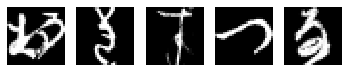

In [26]:
fig = plt.figure()
for i in range(5):
    ax = fig.add_subplot(1, 5, i+1)
    x = train[train_labels==i][0]
    plt.imshow(x.reshape(n, n), cmap='gray')
    plt.axis('off')
plt.savefig('figures/kmnist_clf/kmnist_digits.png')

### Classify

In [4]:
from estimator import gabor_random_features, relu, RFClassifier
import pickle

def l_clf(classifier, params, X_train, y_train, X_test, y_test):
    clf = classifier(**params)
    clf.fit(X_train, y_train)
    return 1 - clf.score(X_test, y_test)

In [5]:
import dask
from dask.distributed import Client
client = Client(threads_per_worker=7, n_workers=10)
client

Client Scheduler: tcp://127.0.0.1:36363 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 10 Cores: 70 Memory: 135.06 GB


In [6]:
X_train, y_train = train.copy(), train_labels.copy()
X_test, y_test = test.copy(), test_labels.copy()

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(60000, 784) (60000,)
(10000, 784) (10000,)


In [7]:
n_features = sorted(set(np.logspace(0, 3, 50).astype('int')))
print(n_features)

t = 5 # scale of bump
l = 3 # scale of wiggles

# weight function
f_gabor = lambda M, N: gabor_random_features(M, N, t, l).T
weights = [('gabor', f_gabor), ('white noise', None)]

# non-linearities
h = relu

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 19, 22, 25, 29, 33, 39, 44, 51, 59, 68, 79, 91, 104, 120, 138, 159, 184, 212, 244, 281, 323, 372, 429, 494, 568, 655, 754, 868, 1000]


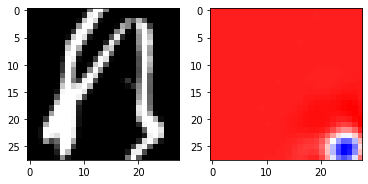

In [8]:
fig = plt.figure()
ax = fig.add_subplot(121)
plt.imshow(X_train[0].reshape(28, 28), cmap='gray')

ax = fig.add_subplot(122)
W = gabor_random_features(3, N, t, l)
plt.imshow(W[0].reshape(28, 28), cmap='bwr')

In [ ]:
# %%time 
# results = {wt:[] for (wt, func) in weights}
# for (wt, func) in weights:
#     for n in n_features:
#         params = {'width': n, 'weights': wt, 'weight_fun': func, 'nonlinearity': h}
#         lazy_results = [dask.delayed(l_clf)(RFClassifier, params, X_train, y_train, X_test, 
#                                             y_test) for _ in range(3)]
#         results[wt].append(np.real(dask.compute(*lazy_results)))
#         print(wt, n)

#         # save
#         with open('figures/kmnist_clf/kmnist_clf_t=%0.2f_l=%0.2f.pickle'% (t, l), 'wb') as handle:
#             pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

gabor 1
gabor 2
gabor 3
gabor 4


In [9]:
with open('figures/kmnist_clf/kmnist_clf_t=%0.2f_l=%0.2f.pickle' % (t, l), 'rb') as handle:
    results = pickle.load(handle)

In [10]:
# compute mean
mean_err_gabor, std_err_gabor = np.mean(results['gabor'], 
                                                    axis=1), np.std(results['gabor'], axis=1)
mean_err_wn, std_err_wn = np.mean(results['white noise'], 
                                              axis=1), np.std(results['white noise'], axis=1)

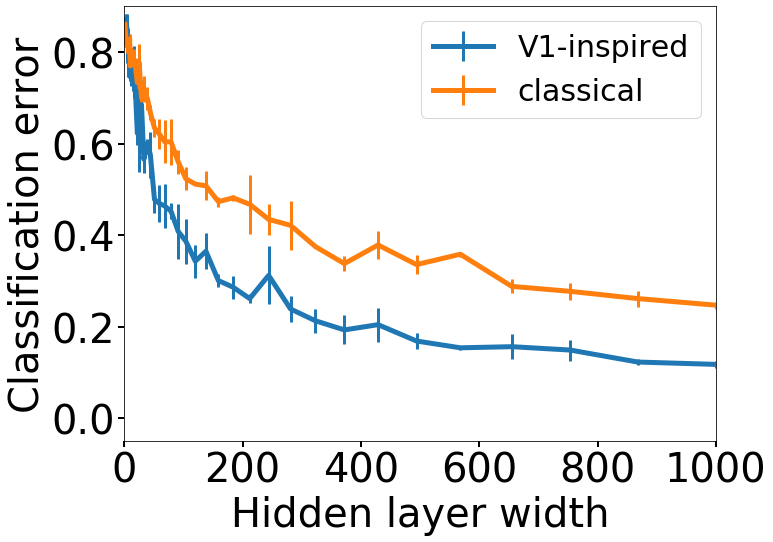

In [28]:
fig = plt.figure(figsize=(10.6, 8))
ax = fig.add_subplot(111)
ax.errorbar(n_features, mean_err_gabor, yerr=std_err_gabor, fmt='-', label='V1-inspired', markersize=4, 
            lw=5, elinewidth=3)
ax.errorbar(n_features, mean_err_wn, yerr=std_err_wn, fmt='-', label='classical',  markersize=4, 
            lw=5, elinewidth=3)
plt.xlabel('Hidden layer width', fontsize=40)
plt.ylabel('Classification error', fontsize=40)
plt.xticks(np.arange(0, 1020, 200))
plt.xlim([0, 1000])
plt.yticks(np.arange(0, 1.2, 0.2))
plt.ylim([-0.05, 0.9])
ax.tick_params(axis = 'both', which = 'major', labelsize = 40, width=2, length=6)
plt.legend(loc = 'upper right', fontsize=30)
plt.savefig('figures/kmnist_clf/clf_t=%0.2f_l=%0.2f.png'% (t, l))

(0.8674333333333334, 0.8605333333333333)